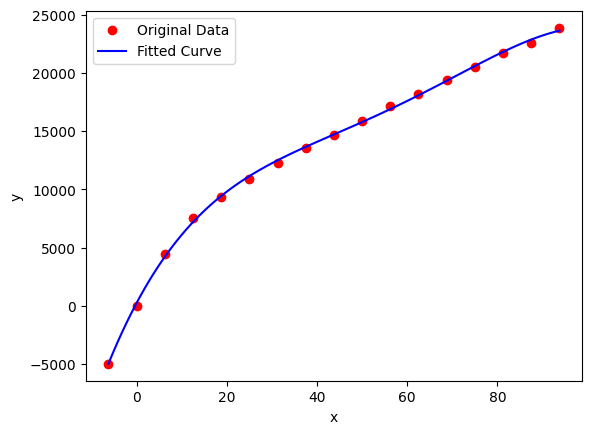

In [604]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

imu_data = np.loadtxt("/home/nuci7/project/cf2/crazyflie-firmware/control/data/imu_data_0126-2028.csv", delimiter=',')

# acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, motor1, motor2, motor3, motor4, current_time, height
# Normalizing the PWM
imu_data[:,6:10] = imu_data[:,6:10]/((1<<16)-1)


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 原始数据
x = np.linspace(0-6.25,93.75,int(93.75/6.25)+2)
y = np.array([-5000, 0, 4485, 7570, 9374, 10885, 12277, 13522, 14691, 15924, 17174, 18179, 19397, 20539, 21692, 22598, 23882])

# 定义多项式函数
def func(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

# 进行曲线拟合
params, params_covariance = curve_fit(func, x, y)

# 提取拟合参数
a = params[0]
b = params[1]
c = params[2]
d = params[3]
e = params[4]

# 生成拟合曲线的x值
x_fit = np.linspace(x.min(), x.max(), 100)

# 计算拟合曲线的y值
y_fit = func(x_fit, a, b, c, d, e)

# 绘制原始数据和拟合曲线
plt.plot(x, y, 'ro', label='Original Data')
plt.plot(x_fit, y_fit, 'b-', label='Fitted Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**Get moter speed RPM**

In [605]:
# def thrust2RPM(m1,m2,):
RPM = func(np.asarray(imu_data[:,6:10]*100), a, b, c, d, e)
# RPM= imu_data[:,6:10]*25000
# RPM = imu_data[:,6:10]
# plt.plot(rpm)

**Get rotation matrix R**

In [606]:
# Convert quaternion to rotation matrix
def rotation_matrix(quat):
    rot_mat = np.ones([3,3])
    a = quat[0]**2
    b = quat[1]**2
    c = quat[2]**2
    d = quat[3]**2
    e = quat[0]*quat[1]
    f = quat[0]*quat[2]
    g = quat[0]*quat[3]
    h = quat[1]*quat[2]
    i = quat[1]*quat[3]
    j = quat[2]*quat[3]
    rot_mat[0,0] = a - b - c + d
    rot_mat[0,1] = 2 * (e - j)
    rot_mat[0,2] = 2 * (f + i)
    rot_mat[1,0] = 2 * (e + j)
    rot_mat[1,1] = -a + b - c + d
    rot_mat[1,2] = 2 * (h - g)
    rot_mat[2,0] = 2 * (f - i)
    rot_mat[2,1] = 2 * (h + g)
    rot_mat[2,2] = -a - b + c + d
    
    return rot_mat

In [607]:
# import math

# def quatdecompress(comp):
#     # 从解压缩整数中提取索引和符号位
#     i_largest = comp >> 30
#     negate = (comp >> 29) & 1

#     # 解压缩四元数的分量
#     quat = [0.0, 0.0, 0.0, 0.0]
#     for i in range(4):
#         if i != i_largest:
#             # 从整数中提取符号位和幅度
#             negbit = (comp >> 28) & 1
#             mag = comp & ((1 << 9) - 1)

#             # 计算原始值
#             value = (mag / ((1 << 9) - 1)) * math.sqrt(2.0)
#             if negbit != negate:
#                 value = -value

#             # 存储解压缩后的分量
#             quat[i] = value

#             # 移动到下一个四元数分量
#             comp >>= 10

#     # 根据最大元素的正负号确定四元数的w分量
#     w = math.sqrt(1.0 - sum(q * q for q in quat))
#     quat[i_largest] = w if negate == 0 else -w

#     return quat

# # 示例使用
# compressed_quat = 3054198967
# uncompressed_quat = quatdecompress(compressed_quat)
# print(uncompressed_quat)

In [608]:
# hhh = []
# for i in range(1668):
#     print(i)    
#     quat = int(imu_data[i,4])
#     compressed_quat = quat # Replace with your compressed quaternion value
#     uncompressed_quat = quatdecompress(compressed_quat)
#     hhh.append(uncompressed_quat[0])
# plt.plot(hhh)
# plt.plot(imu_data[:,3])
# print(uncompressed_quat)  # Output the uncompressed quaternion
# print(imu_data[240,:4])

In [609]:
# 创建旋转矩阵
def rpy2Rotation(roll, pitch, yaw):
    rotation_matrix = np.array([
        [np.cos(yaw)*np.cos(pitch), -np.sin(yaw)*np.cos(roll) + np.cos(yaw)*np.sin(pitch)*np.sin(roll), np.sin(yaw)*np.sin(roll) + np.cos(yaw)*np.sin(pitch)*np.cos(roll)],
        [np.sin(yaw)*np.cos(pitch), np.cos(yaw)*np.cos(roll) + np.sin(yaw)*np.sin(pitch)*np.sin(roll), -np.cos(yaw)*np.sin(roll) + np.sin(yaw)*np.sin(pitch)*np.cos(roll)],
        [-np.sin(pitch), np.cos(pitch)*np.sin(roll), np.cos(pitch)*np.cos(roll)]
    ])
    return rotation_matrix


In [610]:
R = np.zeros([imu_data.shape[0], 3, 3])
for i in range(imu_data.shape[0]):
    R[i, :, :] = rotation_matrix([0,0,0,1])

**Fixed CT to get Fa**

In [611]:
m = 0.0362 # mass
# g = 9.81 # gravity
g = 9.83 # gravity
rho = 1.225 # air density
D = 0.0505  # diameter of the rotor
rpm2rs = 60 ** 2

C_t_fixed = 0.09937873049125099
# C_t_fixed = 0.12037873049125099
Fa = np.zeros([imu_data.shape[0], 3])
F = R[:, :, 2]

In [612]:
# A_d: acceleration rate


for i in range(imu_data.shape[0]):
    F_whole = m * imu_data[i, 0:3]/1000  # G = mg
    # temp[2] += m * g
    r_square = RPM[i, 0]**2 + RPM[i, 1]**2 + RPM[i, 2]**2 + RPM[i, 3]**2
    # r_square = RPM[i, 0]**2*4
    thrust = C_t_fixed / rpm2rs * rho * D ** 4 * r_square # c_t = C_t_fixed / rpm2rs * rho * D ** 4. r_square = n**2+n**2+n**2+n**2
    Fa[i, :] = F_whole - thrust * F[i, :]

**Take a look at Fa**

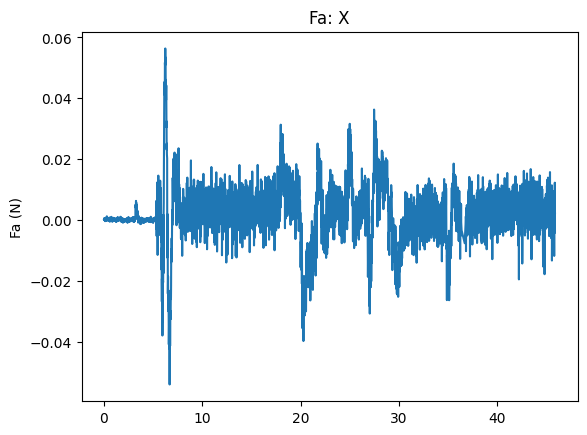

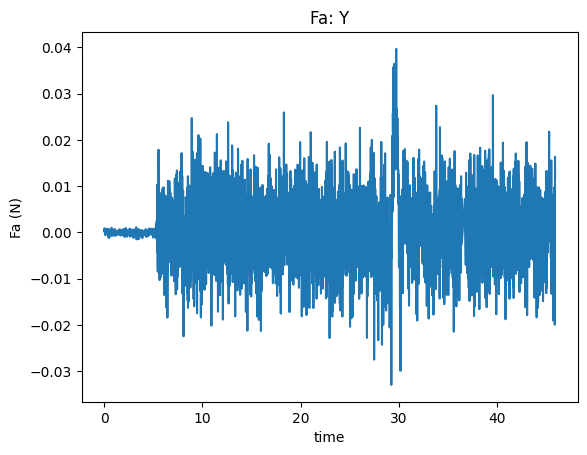

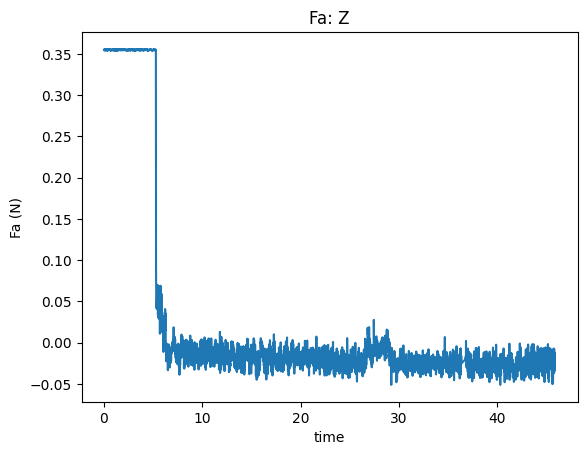

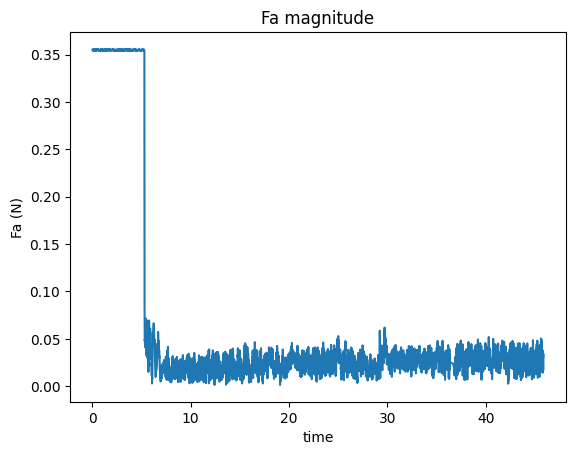

In [613]:
line1, = plt.plot(imu_data[:,-2], Fa[:, 0])
plt.title("Fa: X")
plt.ylabel("Fa (N)")
plt.show()

line1, = plt.plot(imu_data[:,-2], Fa[:, 1])
plt.title("Fa: Y")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

plt.figure()
# line1, = plt.plot(imu_data[1500:,-2], Fa[1500:, 2])
# line1, = plt.plot(imu_data[1500:,-2], imu_data[1500:,-1]/10000)
line1, = plt.plot(imu_data[:,-2], Fa[:,2])
# line1, = plt.plot(imu_data[:,-2], imu_data[:,-1]/10000)
plt.title("Fa: Z")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

Fa_norm = np.zeros(imu_data[:,-2].shape[0])
for i in range(imu_data[:,-2].shape[0]):
    Fa_norm[i] = np.linalg.norm(Fa[i, :])
line1, = plt.plot(imu_data[:,-2], Fa_norm)
plt.title("Fa magnitude")
plt.xlabel("time")
plt.ylabel("Fa (N)")
plt.show()

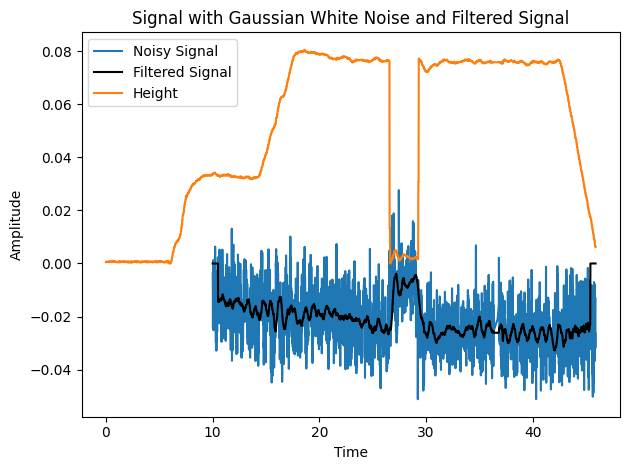

In [614]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 生成原始信号
t = np.linspace(0, 1, 1000)  # 时间范围为0到1，共1000个点
signal = np.sin(2 * np.pi * 10 * t)  # 生成一个频率为10Hz的正弦信号

# 生成高斯白噪声
mean = 0
stddev = 0.1
noise = np.array([random.gauss(mean, stddev) for _ in range(signal.shape[0])])

# 添加噪声到信号
# noisy_signal = signal + noise
noisy_signal = Fa[1000:,2]


# 使用均值滤波进行降噪
window_size = 50
filtered_signal = np.zeros_like(noisy_signal)
filtered_signal2 = np.zeros_like(filtered_signal)
for i in range(window_size, len(noisy_signal) - window_size):
    filtered_signal[i] = np.mean(noisy_signal[i - window_size:i])
    filtered_signal2[i] = np.mean(filtered_signal[i - window_size:i])
    # if filtered_signal2[i] > np.mean(filtered_signal[i - window_size:i]):


# filtered_signal2 = np.zeros_like(filtered_signal)
# for i in range(window_size, len(filtered_signal) - window_size):
#     filtered_signal2[i] = np.mean(filtered_signal[i - window_size:i+window_size])


# 绘制结果
# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# plt.plot(imu_data[:,-2], signal)
# plt.title('Original Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# plt.subplot(2, 1, 2)
plt.plot(imu_data[1000:,-2], noisy_signal)
plt.plot(imu_data[1000:,-2], filtered_signal, color='k')
# plt.plot(imu_data[1000:,-2], filtered_signal2)

plt.plot(imu_data[:,-2], imu_data[:,-1]/10000)

plt.legend(['Noisy Signal', 'Filtered Signal','Height'])
plt.title('Signal with Gaussian White Noise and Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

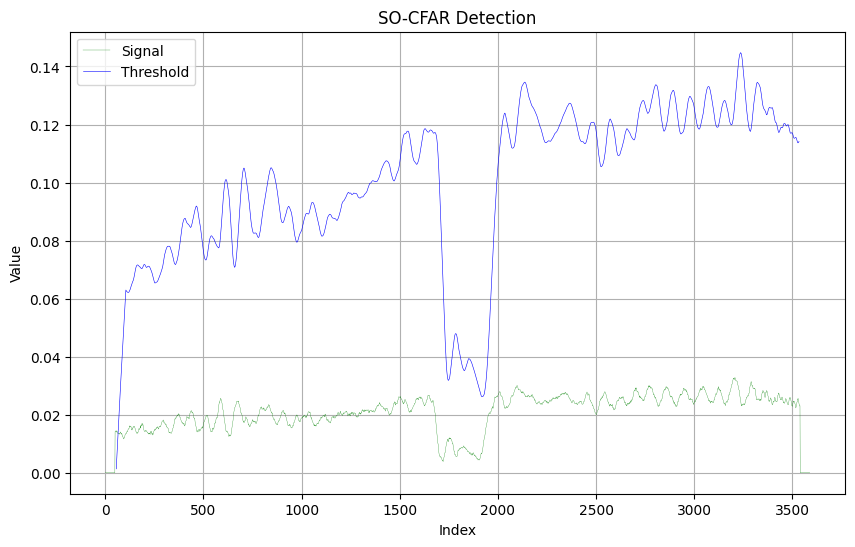

In [615]:
import numpy as np
import matplotlib.pyplot as plt

def cfar_so(xc, N, pro_N, PAD):
    # 假设回波服从高斯分布
    alpha = N * (PAD ** (-1 / N) - 1)
    target = []
    index = np.arange(1 + N/2 + pro_N/2, len(xc) - N/2 - pro_N/2)
    XT = np.zeros(len(index))

    for i in index:
        cell_left = xc[int(i - N/2 - pro_N/2) : int(i - pro_N/2)]
        # cell_right = xc[int(i + pro_N/2 + 1) : int(i + N/2 + pro_N/2 + 1)]
        cell_right = 1e10
        Z = np.min([np.mean(cell_left), np.mean(cell_right)])
        # print(alpha)
        XT[int(i - N/2 - pro_N/2-1)] = Z * alpha
        if xc[int(i)] > Z * alpha:
            target.append(int(i))
    return index, XT, target

# 设置参数

N = 100
pro_N =10
PAF = 1e-2

# 生成噪声信号
# variance = 200
# shape = (200,)
# noise_db = 20
# noise_p = 10**(noise_db/10)
# xc = env_uniform(variance, shape, noise_db)

# # 添加信号
# signal1_p = 10**(SNR1/10) * noise_p
# xc[89] = signal1_p
# xc = gh1[:int(len(gh1)*0.85)]*gh2[:int(len(gh1)*0.85)]*gh3[:int(len(gh1)*0.85)]
# xc = gh1[:int(len(gh1)*0.85)]*gh2[:int(len(gh1)*0.85)]*gh3[:int(len(gh1)*0.85)]*gh4[:int(len(gh1)*0.85)]*gh5[:int(len(gh1)*0.85)]
# xc = imu_data[:,0]
# 应用CFAR算法
xc = abs(filtered_signal)
index, XT, target_idx = cfar_so(xc, N, pro_N, PAF)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(np.abs(xc), 'g',linewidth=0.2, label='Signal')
plt.plot(index, (XT), 'b', linewidth=0.4, label='Threshold')
# plt.scatter(target_idx, XT[np.array(target_idx)-int(N/2+pro_N/2)], color='black', marker='x', label='Target', zorder=2)
# plt.plot(imu_data[:,-1])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('SO-CFAR Detection')
plt.legend()
plt.grid(True)
plt.show()

max_threshold = np.max(XT)
max_threshold_index = np.argmax(XT)

# 从阈值最大点向左搜索第一个目标点
first_target_index = None
for i in range(max_threshold_index+100, -1, -1):
    if i in target_idx:
        first_target_index = i
        break
# version 1    
# t_sta = first_target_index/1000
# t_sam = ((nperseg-noverlap)/fs)
# t_sta_num = round(t_sta/t_sam)
# t_stop_num = None
# for j in range(t_sta_num, 4000, 1):
#     if pp[j]<pp[t_sta_num]:
#         t_stop_num = j
#         break
# t_stop = t_stop_num*t_sam
# t_sta,t_stop
# version 2    
# t_sta = first_target_index/1000
# stop_target_index = None
# for j in range(first_target_index, 3500, 1):
#     print(XT[j-1])
#     if XT[j-1]+max_threshold/3<XT[first_target_index]:
#         stop_target_index = j-1
#         break
# t_stop = stop_target_index/1000
# t_sta,t_stop